# Diseño Amplificador microondas

## Caracterización del Sustrato

## Polarización Y estabilidad

In [ ]:
import os
import numpy as np
import pandas as pd
import skrf as rf

er = 4.4   # Constante dieléctrica del sustrato (por ejemplo FR4)
H = 1.6    # Espesor del dieléctrico en mm



# Ruta de la carpeta que contiene los archivos .s2p
s2p_folder = "/home/mateod/Documents/labo2_EA_III_Ampl_Microondas/BFP450"
target_freq_ghz = 2.200  # Frecuencia objetivo en GHz
Z0 = 50  # Impedancia característica

# Función para calcular K y Delta
def rollet_k(S):
    S11, S21, S12, S22 = S[0, 0], S[1, 0], S[0, 1], S[1, 1]
    delta = S11 * S22 - S12 * S21
    k_num = 1 - abs(S11)**2 - abs(S22)**2 + abs(delta)**2
    k_den = 2 * abs(S12 * S21)
    K = k_num / k_den if k_den != 0 else 0
    return K, delta, S21, S12, S11, S22

# Función para calcular coeficientes de reflexión y Zs
def calcular_coeficientes_refleccion(S11, S22, S12, S21, delta):
    B1 = 1 + abs(S11)**2 - abs(S22)**2 - abs(delta)**2
    B2 = 1 + abs(S22)**2 - abs(S11)**2 - abs(delta)**2
    C1 = S11 - delta * np.conj(S22)
    C2 = S22 - delta * np.conj(S11)

    rho_in_m = np.conj((B1 - np.sqrt(B1**2 - 4 * abs(C1)**2)) / (2 * C1))
    rho_out_m = np.conj((B2 - np.sqrt(B2**2 - 4 * abs(C2)**2)) / (2 * C2))

    Zin = Z0 * (1 + rho_in_m) / (1 - rho_in_m)
    Zout = Z0 * (1 + rho_out_m) / (1 - rho_out_m)

    return rho_in_m, rho_out_m, Zin, Zout




# Recolectar resultados
resultados = []

for file in os.listdir(s2p_folder):
    if file.endswith(".s2p"):
        path = os.path.join(s2p_folder, file)
        
        try:
            net = rf.Network(path)
            freqs_ghz = net.f / 1e9
            idx = np.argmin(np.abs(freqs_ghz - target_freq_ghz))
            
            if abs(freqs_ghz[idx] - target_freq_ghz) > 0.01:
                continue
            
            s = net.s[idx]
            K, delta, S21, S12, S11, S22 = rollet_k(s)

            # Calcular GTmax solo si es incondicionalmente estable
            gt_max_db = None
            if K > 1 and abs(delta) < 1:
                term = (abs(S21) / abs(S12)) * (K - np.sqrt(K**2 - 1))
                gt_max_db = 10 * np.log10(term)

            # Calcular coeficientes de reflexión y Zs
            rho_in_m, rho_out_m, Zin, Zout = calcular_coeficientes_refleccion(S11, S22, S12, S21, delta)

            with open(path, "r") as f:
                lines = f.readlines()
            vce, ic = None, None
            for line in lines:
                if "VCE" in line and "IC" in line:
                    parts = line.split(",")
                    vce = float(parts[0].split("=")[1].strip().replace("V", ""))
                    ic_str = parts[1].split("=")[1].strip()
                    if "mA" in ic_str:
                        ic = float(ic_str.replace("mA", "").strip())
                    elif "A" in ic_str:
                        ic = float(ic_str.replace("A", "").strip()) * 1000
                    break

            if vce is None or ic is None:
                print(f"No se pudo extraer VCE e IC del archivo: {file}")
                continue

            resultados.append({
                "Archivo": file,
                "VCE [V]": vce,
                "IC [mA]": ic,
                "K": round(K, 3),
                "|Δ|": round(abs(delta), 3),
                "Estable": K > 1 and abs(delta) < 1,
                "GTmax [dB]": round(gt_max_db, 2) if gt_max_db is not None else None,
                "rho_in": rho_in_m,
                "rho_out": rho_out_m,
                "Zin": Zin,
                "Zout": Zout
            })

        except Exception as e:
            print(f"Error procesando {file}: {e}")

# Crear DataFrame para análisis
df = pd.DataFrame(resultados)

# Redondear los valores de rho_in, rho_out, Zin y Zout a 4 decimales
df["rho_in"] = df["rho_in"].apply(lambda x: complex(round(x.real, 4), round(x.imag, 4)) if pd.notna(x) else x)
df["rho_out"] = df["rho_out"].apply(lambda x: complex(round(x.real, 4), round(x.imag, 4)) if pd.notna(x) else x)
df["Zin"] = df["Zin"].apply(lambda x: complex(round(x.real, 4), round(x.imag, 4)) if pd.notna(x) else x)
df["Zout"] = df["Zout"].apply(lambda x: complex(round(x.real, 4), round(x.imag, 4)) if pd.notna(x) else x)

# Calcular las partes real e imaginaria de Zin y Zout
df["Rin(s)"] = df["Zin"].apply(lambda z: z.real if pd.notna(z) else None)
df["Xin(s)"] = df["Zin"].apply(lambda z: z.imag if pd.notna(z) else None)
df["Rout(s)"] = df["Zout"].apply(lambda z: z.real if pd.notna(z) else None)
df["Xout(s)"] = df["Zout"].apply(lambda z: z.imag if pd.notna(z) else None)

# Calcular las equivalentes en paralelo
df["Rin(p)"] = df.apply(
    lambda row: row["Rin(s)"] * (1 + (row["Xin(s)"] / row["Rin(s)"])**2) if row["Rin(s)"] and row["Xin(s)"] else None,
    axis=1
)
df["Xin(p)"] = df.apply(
    lambda row: row["Xin(s)"] * (1 + (row["Rin(s)"] / row["Xin(s)"])**2) if row["Rin(s)"] and row["Xin(s)"] else None,
    axis=1
)
df["Rout(p)"] = df.apply(
    lambda row: row["Rout(s)"] * (1 + (row["Xout(s)"] / row["Rout(s)"])**2) if row["Rout(s)"] and row["Xout(s)"] else None,
    axis=1
)
df["Xout(p)"] = df.apply(
    lambda row: row["Xout(s)"] * (1 + (row["Rout(s)"] / row["Xout(s)"])**2) if row["Rout(s)"] and row["Xout(s)"] else None,
    axis=1
)

# Redondear los valores de las equivalentes en paralelo a 4 decimales
df["Rin(p)"] = df["Rin(p)"].apply(lambda x: round(x, 4) if pd.notna(x) else x)
df["Xin(p)"] = df["Xin(p)"].apply(lambda x: round(x, 4) if pd.notna(x) else x)
df["Rout(p)"] = df["Rout(p)"].apply(lambda x: round(x, 4) if pd.notna(x) else x)
df["Xout(p)"] = df["Xout(p)"].apply(lambda x: round(x, 4) if pd.notna(x) else x)

# Calcular las impedancias características del adaptador λ/4
df["Zo(Qwin)"] = df["Rin(p)"].apply(lambda r: round(np.sqrt(50 * r), 4) if pd.notna(r) else None)
df["Zo(Qwout)"] = df["Rout(s)"].apply(lambda r: round(np.sqrt(50 * r), 4) if pd.notna(r) else None)

# Mostrar resultados ordenados por IC [mA]
df = df.sort_values(by="IC [mA]", ascending=True).reset_index(drop=True)
print(df)

# Guardar resultados en un archivo CSV
df.to_csv("resultados_estabilidad_completo.csv", index=False)

/tmp/ipykernel_168213/3604929754.py:27: RuntimeWarning: invalid value encountered in sqrt
  rho_in_m = np.conj((B1 - np.sqrt(B1**2 - 4 * abs(C1)**2)) / (2 * C1))
/tmp/ipykernel_168213/3604929754.py:28: RuntimeWarning: invalid value encountered in sqrt
  rho_out_m = np.conj((B2 - np.sqrt(B2**2 - 4 * abs(C2)**2)) / (2 * C2))
/tmp/ipykernel_168213/3604929754.py:30: RuntimeWarning: invalid value encountered in scalar divide
  Zin = Z0 * (1 + rho_in_m) / (1 - rho_in_m)
/tmp/ipykernel_168213/3604929754.py:31: RuntimeWarning: invalid value encountered in scalar divide
  Zout = Z0 * (1 + rho_out_m) / (1 - rho_out_m)


                                 Archivo  VCE [V]  IC [mA]      K    |Δ|  \
0   BFP450_w_noise_VCE_1.0V_IC_5.0mA.s2p      1.0      5.0  0.898  0.276   
1   BFP450_w_noise_VCE_3.0V_IC_5.0mA.s2p      3.0      5.0  0.886  0.201   
2   BFP450_w_noise_VCE_4.0V_IC_5.0mA.s2p      4.0      5.0  0.877  0.181   
3   BFP450_w_noise_VCE_2.5V_IC_5.0mA.s2p      2.5      5.0  0.889  0.214   
4   BFP450_w_noise_VCE_2.0V_IC_5.0mA.s2p      2.0      5.0  0.893  0.229   
..                                   ...      ...      ...    ...    ...   
81  BFP450_w_noise_VCE_2.5V_IC_0.18A.s2p      2.5    180.0  1.123  0.638   
82  BFP450_w_noise_VCE_1.0V_IC_0.18A.s2p      1.0    180.0  1.176  0.702   
83  BFP450_w_noise_VCE_2.0V_IC_0.18A.s2p      2.0    180.0  1.128  0.645   
84  BFP450_w_noise_VCE_2.0V_IC_0.20A.s2p      2.0    200.0  1.144  0.634   
85  BFP450_w_noise_VCE_1.0V_IC_0.20A.s2p      1.0    200.0  1.210  0.712   

    Estable  GTmax [dB]          rho_in         rho_out              Zin  ...  \
0     

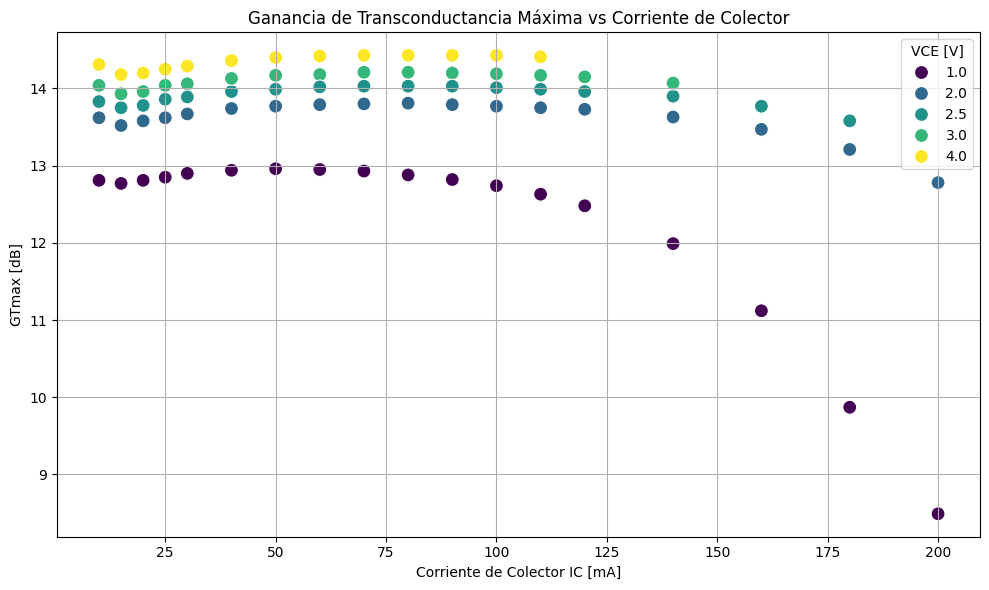

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Solo filas con GTmax definido
df_valid = df[df["GTmax [dB]"].notna()]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_valid, x="IC [mA]", y="GTmax [dB]", hue="VCE [V]", palette="viridis", s=100)

plt.title("Ganancia de Transconductancia Máxima vs Corriente de Colector")
plt.xlabel("Corriente de Colector IC [mA]")
plt.ylabel("GTmax [dB]")
plt.grid(True)
plt.legend(title="VCE [V]")
plt.tight_layout()
plt.show()

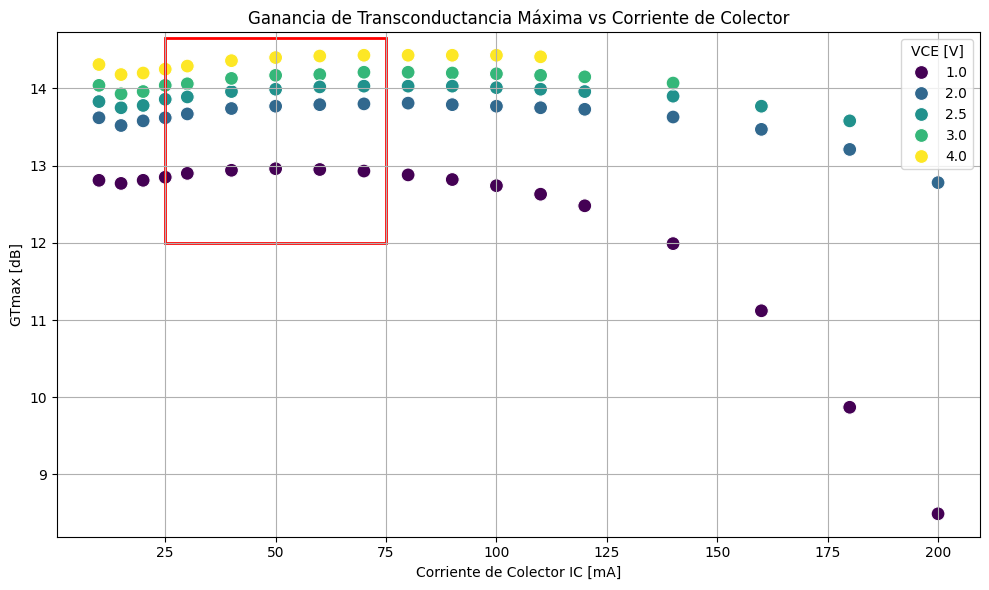

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Solo filas con GTmax definido
df_valid = df[df["GTmax [dB]"].notna()]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_valid, x="IC [mA]", y="GTmax [dB]", hue="VCE [V]", palette="viridis", s=100)

# Agregar un rectángulo rojo para encuadrar los resultados entre 25mA y 75mA, y entre 12dB y 15dB
plt.gca().add_patch(Rectangle(
    (25, 12),  # Coordenada inferior izquierda (x, y)
    50,        # Ancho (75mA - 25mA)
    2.65,         # Altura (15dB - 12dB)
    edgecolor='red',
    facecolor='none',
    linewidth=2
))

# Personalizar el gráfico
plt.title("Ganancia de Transconductancia Máxima vs Corriente de Colector")
plt.xlabel("Corriente de Colector IC [mA]")
plt.ylabel("GTmax [dB]")
plt.grid(True)
plt.legend(title="VCE [V]")
plt.tight_layout()

# Mostrar el gráfico
plt.show()

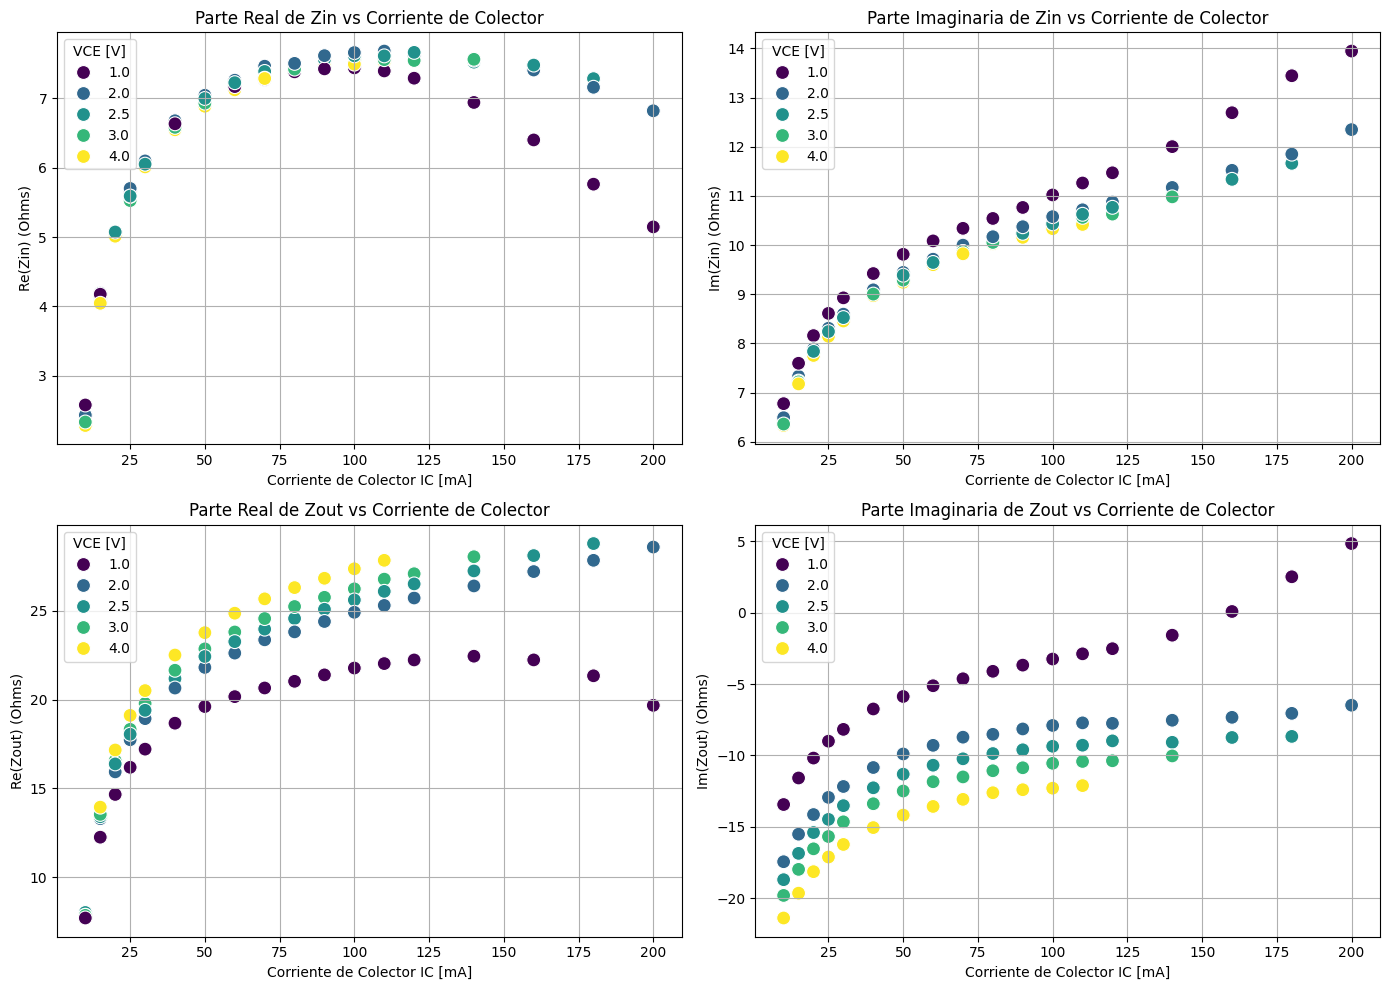

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Solo filas con Zin definido
df_valid_zin = df[df["Zin"].notna()]

# Solo filas con Zout definido
df_valid_zout = df[df["Zout"].notna()]

# Crear figura y subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico para la parte real de Zin
sns.scatterplot(data=df_valid_zin, x="IC [mA]", y=df_valid_zin["Zin"].apply(lambda z: z.real), hue="VCE [V]", palette="viridis", s=100, ax=axes[0, 0])
axes[0, 0].set_title("Parte Real de Zin vs Corriente de Colector")
axes[0, 0].set_xlabel("Corriente de Colector IC [mA]")
axes[0, 0].set_ylabel("Re(Zin) (Ohms)")
axes[0, 0].grid(True)
axes[0, 0].legend(title="VCE [V]")

# Gráfico para la parte imaginaria de Zin
sns.scatterplot(data=df_valid_zin, x="IC [mA]", y=df_valid_zin["Zin"].apply(lambda z: z.imag), hue="VCE [V]", palette="viridis", s=100, ax=axes[0, 1])
axes[0, 1].set_title("Parte Imaginaria de Zin vs Corriente de Colector")
axes[0, 1].set_xlabel("Corriente de Colector IC [mA]")
axes[0, 1].set_ylabel("Im(Zin) (Ohms)")
axes[0, 1].grid(True)
axes[0, 1].legend(title="VCE [V]")

# Gráfico para la parte real de Zout
sns.scatterplot(data=df_valid_zout, x="IC [mA]", y=df_valid_zout["Zout"].apply(lambda z: z.real), hue="VCE [V]", palette="viridis", s=100, ax=axes[1, 0])
axes[1, 0].set_title("Parte Real de Zout vs Corriente de Colector")
axes[1, 0].set_xlabel("Corriente de Colector IC [mA]")
axes[1, 0].set_ylabel("Re(Zout) (Ohms)")
axes[1, 0].grid(True)
axes[1, 0].legend(title="VCE [V]")

# Gráfico para la parte imaginaria de Zout
sns.scatterplot(data=df_valid_zout, x="IC [mA]", y=df_valid_zout["Zout"].apply(lambda z: z.imag), hue="VCE [V]", palette="viridis", s=100, ax=axes[1, 1])
axes[1, 1].set_title("Parte Imaginaria de Zout vs Corriente de Colector")
axes[1, 1].set_xlabel("Corriente de Colector IC [mA]")
axes[1, 1].set_ylabel("Im(Zout) (Ohms)")
axes[1, 1].grid(True)
axes[1, 1].legend(title="VCE [V]")

# Ajustar diseño
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import skrf as rf

er = 4.4   # Constante dieléctrica del sustrato (por ejemplo FR4)
H = 1.6    # Espesor del dieléctrico en mm
c= 3e8    # Velocidad de la luz en m/s
f = 2.2e9  # Frecuencia objetivo en Hz
t = 1  # Espesor de la microtira en mm
lambd = c / f  # Longitud de onda en m
Z0 = 50  # Impedancia característica



# Ruta de la carpeta que contiene los archivos .s2p
s2p_folder = "/home/mateod/Documents/labo2_EA_III_Ampl_Microondas/BFP450"
target_freq_ghz = 2.200  # Frecuencia objetivo en GHz


# Función para calcular K y Delta
def rollet_k(S):
    S11, S21, S12, S22 = S[0, 0], S[1, 0], S[0, 1], S[1, 1]
    delta = S11 * S22 - S12 * S21
    k_num = 1 - abs(S11)**2 - abs(S22)**2 + abs(delta)**2
    k_den = 2 * abs(S12 * S21)
    K = k_num / k_den if k_den != 0 else 0
    return K, delta, S21, S12, S11, S22

# Función para calcular coeficientes de reflexión y Zs
def calcular_coeficientes_refleccion(S11, S22, S12, S21, delta):
    B1 = 1 + abs(S11)**2 - abs(S22)**2 - abs(delta)**2
    B2 = 1 + abs(S22)**2 - abs(S11)**2 - abs(delta)**2
    C1 = S11 - delta * np.conj(S22)
    C2 = S22 - delta * np.conj(S11)

    rho_in_m = np.conj((B1 - np.sqrt(B1**2 - 4 * abs(C1)**2)) / (2 * C1))
    rho_out_m = np.conj((B2 - np.sqrt(B2**2 - 4 * abs(C2)**2)) / (2 * C2))

    Zin = Z0 * (1 + rho_in_m) / (1 - rho_in_m)
    Zout = Z0 * (1 + rho_out_m) / (1 - rho_out_m)

    return rho_in_m, rho_out_m, Zin, Zout

# Función para calcular parámetros de microtira Hammerstad
def calcular_microtira(Z0, er, H):
    # Calcular A y B
    A = Z0 / 60 * np.sqrt((er + 1) / 2) + ((er - 1) / (er + 1)) * (0.23 + 0.11 / er)
    B = 377 * np.pi / (2 * Z0 * np.sqrt(er))

    # Calcular W/H
    # H es un valor fijo, es por ello que lo podemos despejar

    W_H5 = 8 * np.exp(A) / (np.exp(2 * A) - 2)
    W_H6= 2 / np.pi * (B - 1 - np.log(2 * B - 1) + (er - 1) / (2 * er) * (np.log(B - 1) + 0.39 - 0.61 / er))

    if (W_H5 and W_H6)<=2:
        W_H = W_H5
        W=W_H*H
    elif (W_H5 and W_H6) > 2:
        W_H = W_H6
        W = W_H * H
    else:
        print("Error: No se puede calcular W/H")
    
    # Calcular Weff
    if W_H <= (1/2*np.pi):
        Weff = W + (t/np.pi) * (1 + np.log(4 * np.pi * W / t))
    elif W_H > (1/2*np.pi):
        Weff = W + (t/np.pi) * (1 + np.log(2*H/ t))
    else:
        print("Error: No se puede calcular Weff")
    
    

    # Calcular Z0' y er'
    if W_H <= 1:
        erp = ((er+1)/2) + ((er-1)/2)*(1/np.sqrt(1+12*(H/W))+0.04*(1-W_H)**2)
        z0 = 60/np.sqrt(erp)*np.log(8*H/W + 0.25*(W/H))
    elif W_H > 1:
        erp = ((er+1)/2) + ((er-1)/2)*(1/np.sqrt(1+12*(H/W)))
        z0 = 120*np.pi/np.sqrt(erp)/(W/H + 1.393 + 0.667*np.log(W/H + 1.444))


    return W_H, z0, erp, Weff

resultados = []

for file in os.listdir(s2p_folder):
    if file.endswith(".s2p"):
        path = os.path.join(s2p_folder, file)
        
        try:
            net = rf.Network(path)
            freqs_ghz = net.f / 1e9
            idx = np.argmin(np.abs(freqs_ghz - target_freq_ghz))
            
            if abs(freqs_ghz[idx] - target_freq_ghz) > 0.01:
                continue
            
            s = net.s[idx]
            K, delta, S21, S12, S11, S22 = rollet_k(s)

            # Calcular GTmax solo si es incondicionalmente estable
            gt_max_db = None
            if K > 1 and abs(delta) < 1:
                term = (abs(S21) / abs(S12)) * (K - np.sqrt(K**2 - 1))
                gt_max_db = 10 * np.log10(term)


            # Calcular coeficientes de reflexión y Zs
            rho_in_m, rho_out_m, Zin, Zout = calcular_coeficientes_refleccion(S11, S22, S12, S21, delta)

            with open(path, "r") as f:
                lines = f.readlines()
            vce, ic = None, None
            for line in lines:
                if "VCE" in line and "IC" in line:
                    parts = line.split(",")
                    vce = float(parts[0].split("=")[1].strip().replace("V", ""))
                    ic_str = parts[1].split("=")[1].strip()
                    if "mA" in ic_str:
                        ic = float(ic_str.replace("mA", "").strip())
                    elif "A" in ic_str:
                        ic = float(ic_str.replace("A", "").strip()) * 1000
                    break

            if vce is None or ic is None:
                print(f"No se pudo extraer VCE e IC del archivo: {file}")
                continue

            resultados.append({
                "Archivo": file,
                "VCE [V]": vce,
                "IC [mA]": ic,
                "K": round(K, 3),
                "|Δ|": round(abs(delta), 3),
                "Estable": K > 1 and abs(delta) < 1,
                "GTmax [dB]": round(gt_max_db, 2) if gt_max_db is not None else None,
                "rho_in": rho_in_m,
                "rho_out": rho_out_m,
                "Zin": Zin,
                "Zout": Zout
            })

        except Exception as e:
            print(f"Error procesando {file}: {e}")

# Crear DataFrame para análisis
df = pd.DataFrame(resultados)

# Redondear los valores de rho_in, rho_out, Zin y Zout a 4 decimales
df["rho_in"] = df["rho_in"].apply(lambda x: complex(round(x.real, 4), round(x.imag, 4)) if pd.notna(x) else x)
df["rho_out"] = df["rho_out"].apply(lambda x: complex(round(x.real, 4), round(x.imag, 4)) if pd.notna(x) else x)
df["Zin"] = df["Zin"].apply(lambda x: complex(round(x.real, 4), round(x.imag, 4)) if pd.notna(x) else x)
df["Zout"] = df["Zout"].apply(lambda x: complex(round(x.real, 4), round(x.imag, 4)) if pd.notna(x) else x)

# Calcular las partes real e imaginaria de Zin y Zout
df["Rin(s)"] = df["Zin"].apply(lambda z: z.real if pd.notna(z) else None)
df["Xin(s)"] = df["Zin"].apply(lambda z: z.imag if pd.notna(z) else None)
df["Rout(s)"] = df["Zout"].apply(lambda z: z.real if pd.notna(z) else None)
df["Xout(s)"] = df["Zout"].apply(lambda z: z.imag if pd.notna(z) else None)

# Calcular las equivalentes en paralelo
df["Rin(p)"] = df.apply(
    lambda row: row["Rin(s)"] * (1 + (row["Xin(s)"] / row["Rin(s)"])**2) if row["Rin(s)"] and row["Xin(s)"] else None,
    axis=1
)
df["Xin(p)"] = df.apply(
    lambda row: row["Xin(s)"] * (1 + (row["Rin(s)"] / row["Xin(s)"])**2) if row["Rin(s)"] and row["Xin(s)"] else None,
    axis=1
)
df["Rout(p)"] = df.apply(
    lambda row: row["Rout(s)"] * (1 + (row["Xout(s)"] / row["Rout(s)"])**2) if row["Rout(s)"] and row["Xout(s)"] else None,
    axis=1
)

# Calcular impedancias características del adaptador λ/4 (debe estar antes de Xout(p))
df["Zo(Qwin)"] = df["Rin(p)"].apply(lambda r: round(np.sqrt(50 * r), 4) if pd.notna(r) else None)
df["Zo(Qwout)"] = df["Rout(s)"].apply(lambda r: round(np.sqrt(50 * r), 4) if pd.notna(r) else None)

# Ahora que ya tenemos Zo(Qwout), podemos calcular Xout(p)
df["Xout(p)"] = df.apply(
    lambda row: ((-1)*row["Zo(Qwout)"]**2 / row["Xout(s)"]) if row["Zo(Qwout)"] and row["Xout(s)"] else None,
    axis=1
)

# Redondear los valores de las equivalentes en paralelo a 4 decimales
df["Rin(p)"] = df["Rin(p)"].apply(lambda x: round(x, 4) if pd.notna(x) else x)
df["Xin(p)"] = df["Xin(p)"].apply(lambda x: round(x, 4) if pd.notna(x) else x)
df["Rout(p)"] = df["Rout(p)"].apply(lambda x: round(x, 4) if pd.notna(x) else x)
df["Xout(p)"] = df["Xout(p)"].apply(lambda x: round(x, 4) if pd.notna(x) else x)

# Calcular parámetros de microtira para Qwin
df["W/H (Qwin)"], df["Zo'(Qwin)"], df["er'(Qwin)"], df["Weff (Qwin)"] = zip(*df["Zo(Qwin)"].apply(
    lambda z: calcular_microtira(z, er, H) if pd.notna(z) else (None, None, None, None)
))

# Calcular parámetros de microtira para Qwout
df["W/H (Qwout)"], df["Zo'(Qwout)"], df["er'(Qwout)"], df["Weff (Qwout)"] = zip(*df["Zo(Qwout)"].apply(
    lambda z: calcular_microtira(z, er, H) if pd.notna(z) else (None, None, None, None)
))

# Redondear los valores a 4 decimales
for col in ["W/H (Qwin)", "Zo'(Qwin)", "er'(Qwin)", "Weff (Qwin)", 
            "W/H (Qwout)", "Zo'(Qwout)", "er'(Qwout)", "Weff (Qwout)"]:
    df[col] = df[col].apply(lambda x: round(x, 4) if pd.notna(x) else x)

# Calcular el ancho W de las microtiras
df["W (Qwin)"] = df["W/H (Qwin)"].apply(lambda wh: round(H * wh, 4) if pd.notna(wh) else None)
df["W (Qwout)"] = df["W/H (Qwout)"].apply(lambda wh: round(H * wh, 4) if pd.notna(wh) else None)



# Calcular lambda y lambda/4
c = 3e11  # Velocidad de la luz en mm/s
f = 2.2e9  # Frecuencia en Hz

df["lambda"] = c / f
df["lambda/4"] = df["lambda"] / 4

# Calcular lambda en dieléctrico y lambda/4
df["lambda_p"] = df["lambda"] / df["er'(Qwin)"].apply(lambda erp: np.sqrt(erp) if pd.notna(erp) else None)
df["lambda_p/4"] = df["lambda_p"] / 4

# Redondear longitudes
for col in ["lambda", "lambda/4", "lambda_p", "lambda_p/4"]:
    df[col] = df[col].apply(lambda x: round(x, 4) if pd.notna(x) else x)

# Calcular los capacitores de entrada y salida
df["Cin"] = df.apply(
    lambda row: 1 / (2 * np.pi * f * row["Xin(p)"]) if pd.notna(row["Xin(p)"]) and row["Xin(p)"] != 0 else None,
    axis=1
)
df["Cout"] = df.apply(
    lambda row: 1 / (2 * np.pi * f * row["Xout(p)"]) if pd.notna(row["Xout(p)"]) and row["Xout(p)"] != 0 else None,
    axis=1
)


# Mostrar resultados ordenados por IC [mA]
df = df.sort_values(by="IC [mA]", ascending=True).reset_index(drop=True)
print(df)

# Guardar resultados en un archivo CSV
df.to_csv("resultados_microtira_lambda.csv", index=False)



/tmp/ipykernel_5094/2129118669.py:37: RuntimeWarning: invalid value encountered in sqrt
  rho_in_m = np.conj((B1 - np.sqrt(B1**2 - 4 * abs(C1)**2)) / (2 * C1))
/tmp/ipykernel_5094/2129118669.py:38: RuntimeWarning: invalid value encountered in sqrt
  rho_out_m = np.conj((B2 - np.sqrt(B2**2 - 4 * abs(C2)**2)) / (2 * C2))
/tmp/ipykernel_5094/2129118669.py:40: RuntimeWarning: invalid value encountered in scalar divide
  Zin = Z0 * (1 + rho_in_m) / (1 - rho_in_m)
/tmp/ipykernel_5094/2129118669.py:41: RuntimeWarning: invalid value encountered in scalar divide
  Zout = Z0 * (1 + rho_out_m) / (1 - rho_out_m)


                                 Archivo  VCE [V]  IC [mA]      K    |Δ|  \
0   BFP450_w_noise_VCE_1.0V_IC_5.0mA.s2p      1.0      5.0  0.898  0.276   
1   BFP450_w_noise_VCE_3.0V_IC_5.0mA.s2p      3.0      5.0  0.886  0.201   
2   BFP450_w_noise_VCE_4.0V_IC_5.0mA.s2p      4.0      5.0  0.877  0.181   
3   BFP450_w_noise_VCE_2.5V_IC_5.0mA.s2p      2.5      5.0  0.889  0.214   
4   BFP450_w_noise_VCE_2.0V_IC_5.0mA.s2p      2.0      5.0  0.893  0.229   
..                                   ...      ...      ...    ...    ...   
81  BFP450_w_noise_VCE_2.5V_IC_0.18A.s2p      2.5    180.0  1.123  0.638   
82  BFP450_w_noise_VCE_1.0V_IC_0.18A.s2p      1.0    180.0  1.176  0.702   
83  BFP450_w_noise_VCE_2.0V_IC_0.18A.s2p      2.0    180.0  1.128  0.645   
84  BFP450_w_noise_VCE_2.0V_IC_0.20A.s2p      2.0    200.0  1.144  0.634   
85  BFP450_w_noise_VCE_1.0V_IC_0.20A.s2p      1.0    200.0  1.210  0.712   

    Estable  GTmax [dB]          rho_in         rho_out              Zin  ...  \
0     

Archivo 'resultados_filtrados.csv' generado con los datos filtrados.


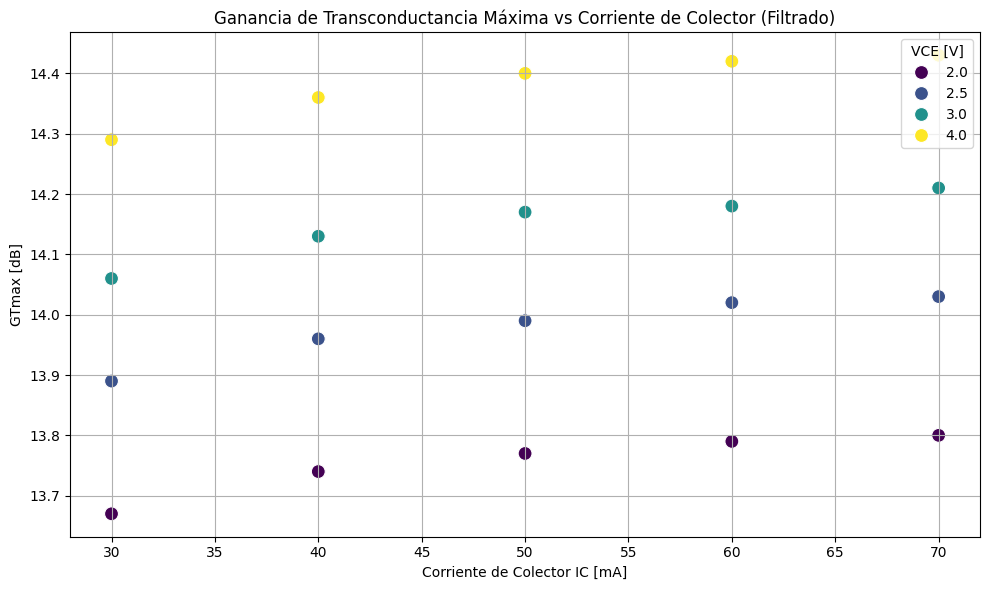

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar las polarizaciones según las condiciones
df_filtrado = df[
    (df["IC [mA]"] >= 30) & (df["IC [mA]"] <= 70) &  # Corriente entre 30mA y 70mA
    (df["GTmax [dB]"] >= 13.5) & (df["GTmax [dB]"] <= 14.5) &  # Ganancia entre 13.5 y 14.5
    (df["lambda_p/4"] / df["Weff"] >= 2) & (df["lambda_p/4"] / df["Weff"] <= 4)  # Relación entre 2 y 4
]

# Guardar los datos filtrados en un archivo CSV
df_filtrado.to_csv("resultados_filtrados.csv", index=False)

# Mensaje para confirmar que el archivo se generó
print("Archivo 'resultados_filtrados.csv' generado con los datos filtrados.")

# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtrado, x="IC [mA]", y="GTmax [dB]", hue="VCE [V]", palette="viridis", s=100)

# Personalizar el gráfico
plt.title("Ganancia de Transconductancia Máxima vs Corriente de Colector (Filtrado)")
plt.xlabel("Corriente de Colector IC [mA]")
plt.ylabel("GTmax [dB]")
plt.grid(True)
plt.legend(title="VCE [V]")
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Elegiriamos 40mA y 4V

Archivo 'resultados_filtrados.csv' generado con los datos filtrados.


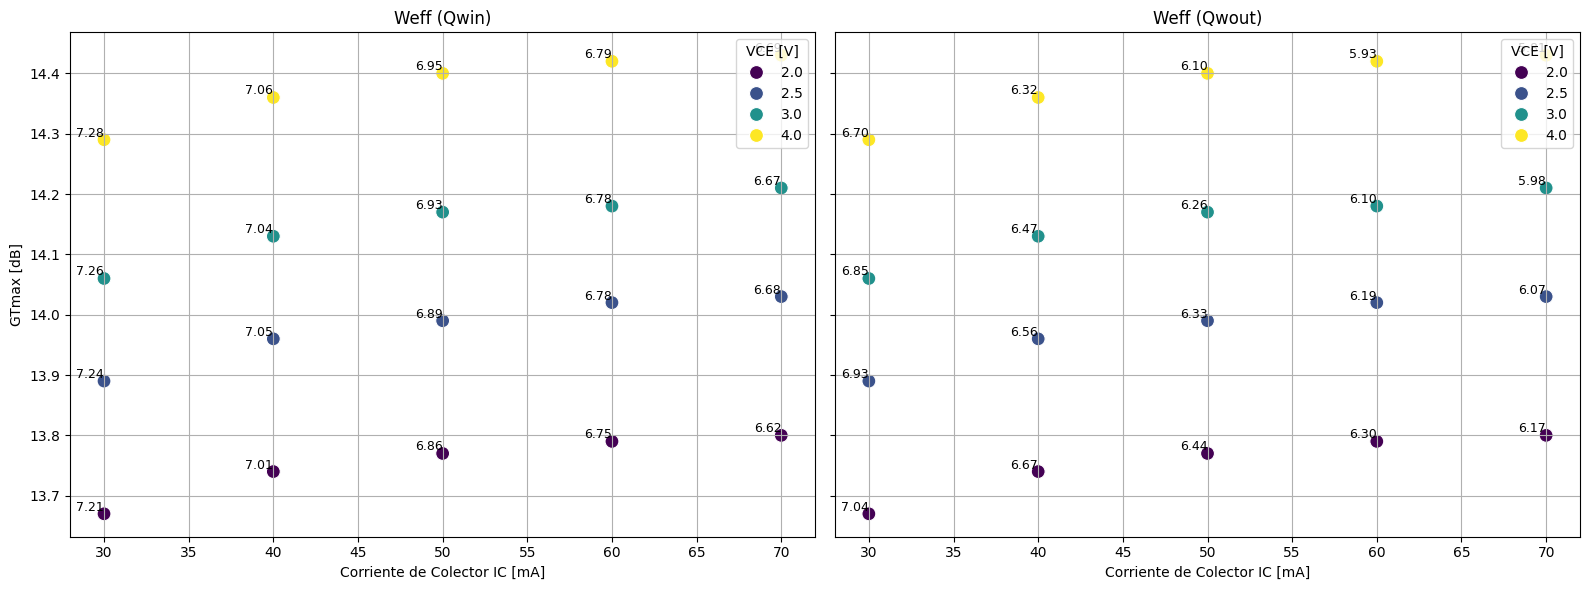

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar las polarizaciones según las condiciones
df_filtrado = df[
    (df["IC [mA]"] >= 30) & (df["IC [mA]"] <= 70) &  # Corriente entre 30mA y 70mA
    (df["GTmax [dB]"] >= 13.5) & (df["GTmax [dB]"] <= 14.5) &  # Ganancia entre 13.5 y 14.5
    (df["lambda_p/4"] / df["Weff (Qwin)"] >= 2) & (df["lambda_p/4"] / df["Weff (Qwin)"] <= 4) &  # Relación para Qwin
    (df["lambda_p/4"] / df["Weff (Qwout)"] >= 2) & (df["lambda_p/4"] / df["Weff (Qwout)"] <= 4)  # Relación para Qwout
]

# Guardar los datos filtrados en un archivo CSV
df_filtrado.to_csv("resultados_filtrados.csv", index=False)

# Mensaje para confirmar que el archivo se generó
print("Archivo 'resultados_filtrados.csv' generado con los datos filtrados.")

# Crear figura y subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Gráfico para Weff (Qwin)
scatter_qwin = sns.scatterplot(
    data=df_filtrado,
    x="IC [mA]",
    y="GTmax [dB]",
    hue="VCE [V]",
    palette="viridis",
    s=100,
    ax=axes[0]
)
for i in range(len(df_filtrado)):
    axes[0].text(
        x=df_filtrado["IC [mA]"].iloc[i],
        y=df_filtrado["GTmax [dB]"].iloc[i],
        s=f"{df_filtrado['Weff (Qwin)'].iloc[i]:.2f}",  # Formato con 2 decimales
        fontsize=9,
        ha='right',  # Alinear a la derecha
        va='bottom'  # Alinear en la parte inferior
    )
axes[0].set_title("Weff (Qwin)")
axes[0].set_xlabel("Corriente de Colector IC [mA]")
axes[0].set_ylabel("GTmax [dB]")
axes[0].grid(True)

# Gráfico para Weff (Qwout)
scatter_qwout = sns.scatterplot(
    data=df_filtrado,
    x="IC [mA]",
    y="GTmax [dB]",
    hue="VCE [V]",
    palette="viridis",
    s=100,
    ax=axes[1]
)
for i in range(len(df_filtrado)):
    axes[1].text(
        x=df_filtrado["IC [mA]"].iloc[i],
        y=df_filtrado["GTmax [dB]"].iloc[i],
        s=f"{df_filtrado['Weff (Qwout)'].iloc[i]:.2f}",  # Formato con 2 decimales
        fontsize=9,
        ha='right',  # Alinear a la derecha
        va='bottom'  # Alinear en la parte inferior
    )
axes[1].set_title("Weff (Qwout)")
axes[1].set_xlabel("Corriente de Colector IC [mA]")
axes[1].grid(True)

# Ajustar diseño
plt.tight_layout()
plt.show()